# Project - First Requirement

### Include packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm    # Just to plot distribution of valuations
from scipy import optimize

### The first thing to do is to code the environment.

In [2]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [3]:
class PricingEnvironmentSingleProduct:
    def __init__(self, valuations, cost):
        self.valuations = valuations
        self.cost = cost

    def round(self, p_t):
        num_of_sales = np.sum(self.valuations >= p_t)       # Count how many customers are willing to pay at least p_t
        reward = (p_t - self.cost) * num_of_sales           # Count the profit subtracting the cost from the price for each sale
        return num_of_sales, reward

### Now define the setting...

In [4]:
# --- Global Settings ---

np.random.seed(30)

T = 20000                 # Time horizon (number of rounds)
n_trials = 100            # Number of independent trials for averaging
N = 1                     # Number of products (unused in this version)

# --- Pricing Grid and Product Info ---

min_p = 0.0
max_p = 5.0
price_step = 0.5
P = np.linspace(min_p, max_p, int((max_p - min_p) / price_step) + 1)  # Discrete set of prices
K = len(P)                        # Number of price options (arms)

cost = 2.00                       # Unit production cost
value = 3.00                      # True mean customer valuation

assert cost < value, "Cost must be less than value"

# --- Market and Inventory Parameters ---

B = 120000                         # Total inventory available (seller capacity)

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50
assert buyers_per_round >= 1, "Must have at least one buyer per round"

### Expected demand and profit using theoretical expectations.

In [5]:
# In our setting, customer valuations are drawn from a normal distribution.
# Given this assumption, we can analytically compute the expected demand at each price p.
# It can be proven that the expected demand is given by: 

def expected_demand(p):
    return np.sum(1 - norm.cdf(p, loc=np.full(buyers_per_round, value), scale=1.0))

# This results in a smooth probability-based estimation of demand for each price p,
# where the probability for a single customer to buy is the tail area of the normal distribution beyond p.

expected_demand_vector = np.array([expected_demand(p) for p in P])
expected_profit_vector = (P - cost) * expected_demand_vector

best_expected_index = np.argmax(expected_profit_vector)
best_expected_price = P[best_expected_index]
best_expected_profit = expected_profit_vector[best_expected_index]

### Realized demand and profit based on a sample.

In [6]:
# --- Initialize Customer Valuations ---

valuations = np.random.normal(loc=value, scale=1.0, size=buyers_per_round)

# --- Environment Setup ---

env = PricingEnvironmentSingleProduct(valuations=valuations, cost=cost)

# Here we show the demand curve after drawing the customers evaluations.

def realized_demand(valuations, p):
    return np.sum(valuations >= p)

realized_demand_vector = np.array([realized_demand(valuations, p) for p in P])
realized_profit_vector = (P - cost) * realized_demand_vector

best_realized_index = np.argmax(realized_profit_vector)
best_realized_price = P[best_realized_index]
best_realized_profit = realized_profit_vector[best_realized_index]

### Let us visualize our setting.

Max expected profit (theoretical): 25.0
...at price: 3.0
Max realized profit (empirical): 27.0
...at price: 3.5


/var/folders/zn/rf3j_pdd4_d02m04l2_1fjcw0000gn/T/ipykernel_34576/1638230874.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


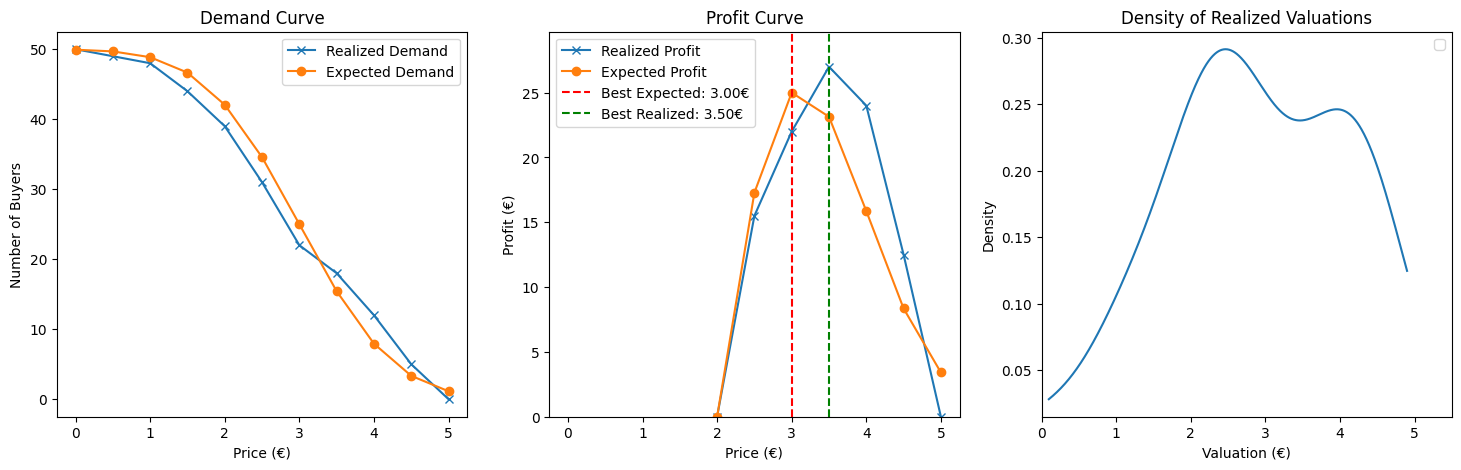

In [7]:
# --- Summary of Results ---

print("Max expected profit (theoretical):", round(best_expected_profit, 2))
print("...at price:", round(best_expected_price, 2))

print("Max realized profit (empirical):", round(best_realized_profit, 2))
print("...at price:", round(best_realized_price, 2))

# --- Plots: Expected vs Realized Demand and Profit ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Demand comparison
axs[0].plot(P, realized_demand_vector, label='Realized Demand', marker='x')
axs[0].plot(P, expected_demand_vector, label='Expected Demand', marker='o')
axs[0].set_title("Demand Curve")
axs[0].set_xlabel("Price (€)")
axs[0].set_ylabel("Number of Buyers")
axs[0].legend()

# Profit comparison
axs[1].plot(P, realized_profit_vector, label='Realized Profit', marker='x')
axs[1].plot(P, expected_profit_vector, label='Expected Profit', marker='o')
axs[1].axvline(best_expected_price, color='r', linestyle='--', label=f"Best Expected: {best_expected_price:.2f}€")
axs[1].axvline(best_realized_price, color='g', linestyle='--', label=f"Best Realized: {best_realized_price:.2f}€")
axs[1].set_title("Profit Curve")
axs[1].set_xlabel("Price (€)")
axs[1].set_ylabel("Profit (€)")
axs[1].legend()
# Automatically adjust y-axis to show just above the lowest observed positive profit
positive_profits = np.concatenate([expected_profit_vector, realized_profit_vector])
ymin = max(min(positive_profits[positive_profits > 0].min(), 0), 0)
ymax = positive_profits.max() * 1.1  # a bit of margin on top
axs[1].set_ylim(ymin, ymax)

# KDE of sampled valuations
x_vals = np.linspace(min(valuations), max(valuations), 1000)
axs[2].plot(x_vals, gaussian_kde(valuations)(x_vals))
axs[2].set_xlim(min_p, max_p*1.1)
axs[2].set_title("Density of Realized Valuations")
axs[2].set_xlabel("Valuation (€)")
axs[2].set_ylabel("Density")
axs[2].legend()

### How can I interact with this environment? We use Agents.

In [8]:
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

### Define the UCB1 Agent.

In [9]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.

class UCB1Agent(Agent):
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K: # In the first K rounds, we sample each arm once
            self.a_t = self.t
        else:   
            ucbs = self.average_rewards + self.range * np.sqrt( 2 * np.log(self.T) / self.N_pulls )
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += ( r_t - self.average_rewards[self.a_t] ) / self.N_pulls[self.a_t]
        self.t += 1

### E.g. Instantaneous Regret - Single run.

In the following example (seed=30, at least 25k rounds), we show that analysing the regret over a single run might be meaningless, using the "a priori" clairvoyant assumptions. In a pricing scenario, it is crucial to carefully define what we mean by a "clairvoyant" benchmark, as different definitions can lead to significantly different interpretations of algorithmic performance. When using the "a priori" expected-optimal price — i.e., the price that maximizes expected profit under the assumed demand distribution — we implicitly assume that the seller does not know the exact valuations of arriving buyers; however, in a realized setting, where buyer valuations are drawn once and fixed throughout the episode, a truly clairvoyant seller would exploit this knowledge to set the price that maximizes profit given the actual observed valuations. 

In [10]:
R = (max(P)-cost) * buyers_per_round

A priori expected best price (a priori clairvoyant): 3.0
A posteriori realized best price (a posteriori clairvoyant): 3.5


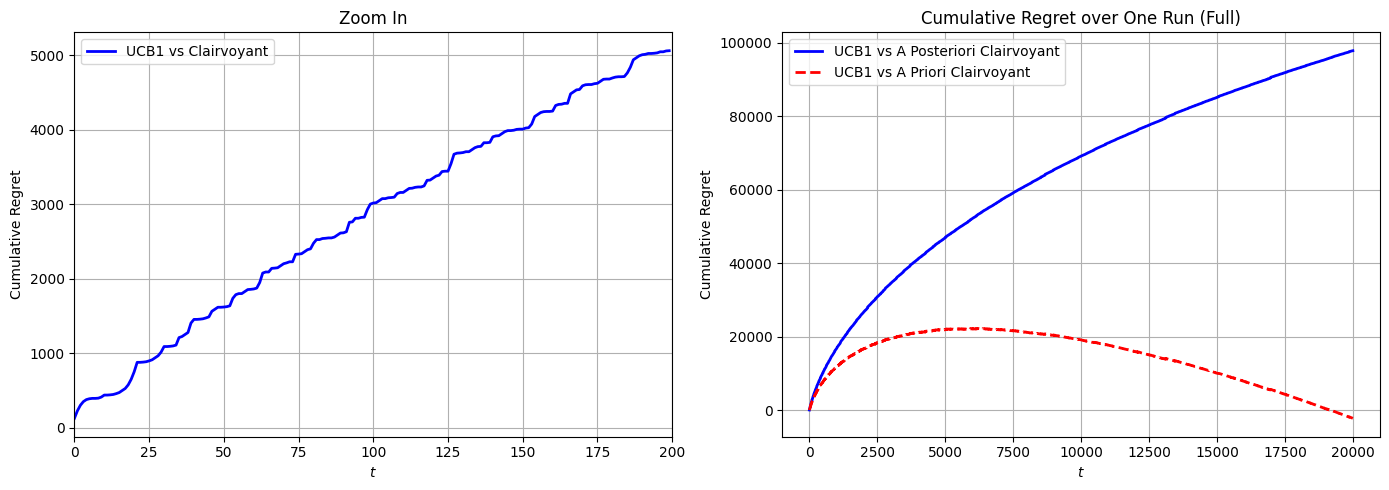

In [11]:
# --- Single run to compare realized rewards ---

# Compute clairvoyant rewards
clairvoyant_expected_rewards = np.array([env.round(P[best_expected_index])[1] for _ in range(T)])
clairvoyant_realized_rewards = np.array([env.round(P[best_realized_index])[1] for _ in range(T)])

# Run UCB1
ucb_agent = UCB1Agent(K, T, range=R)
agent_rewards = np.array([])
pull_counts = np.zeros(K, dtype=int)  # <-- Track number of times each arm is pulled
for t in range(T):
    pi_t = ucb_agent.pull_arm()
    p_t = P[pi_t]
    d_t, r_t = env.round(p_t)
    ucb_agent.update(r_t)
    agent_rewards = np.append(agent_rewards, r_t)
    pull_counts[pi_t] += 1

# Compute most played price
most_played_action = np.argmax(pull_counts)
most_played_price = P[most_played_action]

# Compute realized regret
realized_regret = np.cumsum(clairvoyant_realized_rewards - agent_rewards)
expected_regret = np.cumsum(clairvoyant_expected_rewards - agent_rewards)

print("A priori expected best price (a priori clairvoyant):", round(best_expected_price, 2))
print("A posteriori realized best price (a posteriori clairvoyant):", round(best_realized_price, 2))

# --- Plots ---

zoom_T = int(T * 0.01)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Zoom
ax1.plot(np.arange(zoom_T), realized_regret[:zoom_T], 'b-', linewidth=2, label='UCB1 vs Clairvoyant')
ax1.set_xlim(0, zoom_T)
ax1.set_title('Zoom In')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Cumulative Regret')
ax1.legend()
ax1.grid(True)

# Full
ax2.plot(np.arange(T), realized_regret, 'b-', linewidth=2, label='UCB1 vs A Posteriori Clairvoyant')
ax2.plot(np.arange(T), expected_regret, 'r--', linewidth=2, label='UCB1 vs A Priori Clairvoyant')
ax2.set_title('Cumulative Regret over One Run (Full)')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Cumulative Regret')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### Let's see in which arms the algorithm spent more time.

Pull counts for each price (arm): [  25.   39.   67.  143.  386. 1304. 3100. 9120. 4465.  965.  386.]


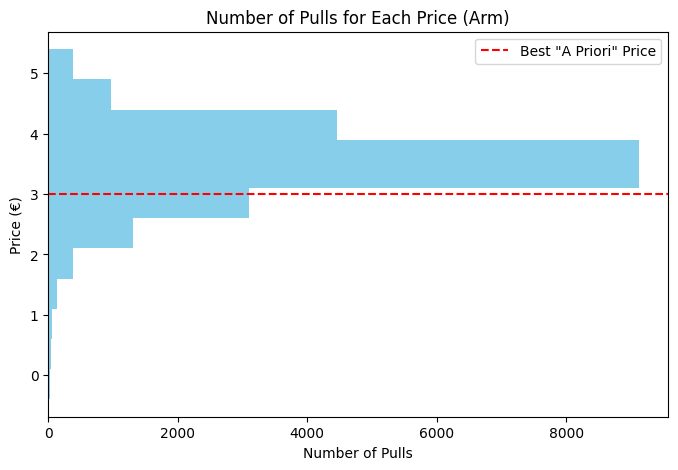

In [12]:
# Print pull counts
print("Pull counts for each price (arm):", ucb_agent.N_pulls)

# --- UCB1 Agent ---
plt.figure(figsize=(8, 5))
plt.barh(P, ucb_agent.N_pulls, color='skyblue')  # Usa i prezzi come y invece degli indici
plt.axhline(P[best_expected_index], color='red', linestyle='--', label='Best "A Priori" Price')  # Linea orizzontale al prezzo migliore
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
plt.legend()

### Pseudo Regret - Estimation


Since it is very complex to compute the theoretical Expected Regret (nor Pseudo) at each round - due to the complex stochasticity in the choice of the action... We estimate it by computing it as the average cumulative regret per round, over many trials. To do this, we use the expected reward of both the clairvoyant and the agent actions, to reduce the variability of the estimation.

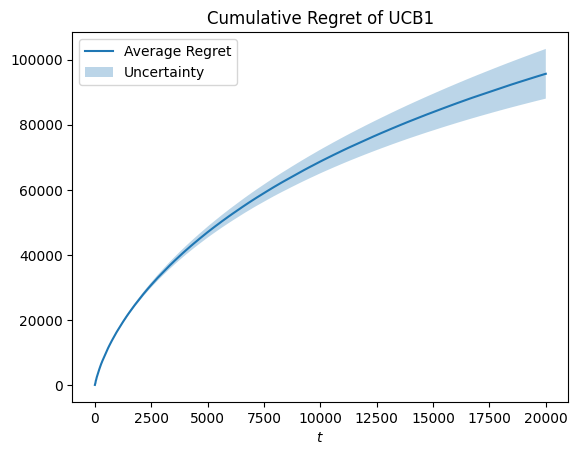

In [13]:
# Compute cumulative regret over multiple trials
regret_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_expected_profit, T)       # We can use the best expected profit because it is on expectation

for seed in range(n_trials):
    np.random.seed(seed)
    
    # Create environment using new valuations
    valuations = np.random.normal(loc=value, scale=1.0, size=buyers_per_round)
    env = PricingEnvironmentSingleProduct(valuations, cost=cost)
    
    # Initialize
    ucb_agent = UCB1Agent(K, T, range=R)
    agent_rewards = np.array([])

    # Run UCB1 for T rounds
    for t in range(T):
        pi_t = ucb_agent.pull_arm()
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

# Compute average (and standard deviation) of regret
average_regret = np.array(regret_per_trial).mean(axis=0)
regret_sd = np.array(regret_per_trial).std(axis=0)

# Plot cumulative regret
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative Regret of UCB1')
plt.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, label='Uncertainty')
plt.xlabel('$t$')
plt.legend()

### Let's introduce a maximum capacity for the seller: UCB-LIKE AGENT.

In [14]:
# --- Agent ---
class UCBLikeInventoryAgent():
    def __init__(self, K, B, T, range=1):
        self.K = K                      # Number of prices
        self.T = T                      # Horizon
        self.range = range              # Confidence scaling factor
        self.a_t = None                 # Last chosen arm index
        self.avg_f = np.zeros(K)        # Average reward per arm
        self.avg_c = np.zeros(K)        # Average consumption per arm
        self.N_pulls = np.zeros(K)      # Number of pulls per arm
        self.inventory = B              # Total inventory (instead of budget)
        self.rho = B / T                # Average allowed consumption per round
        self.t = 0                      # Current round

    def pull_arm(self, return_gamma=False):
        if self.inventory < 1:
            self.a_t = None
            return (None, None) if return_gamma else None

        if self.t < self.K:
            self.a_t = self.t
            gamma = np.zeros(self.K)
            gamma[self.a_t] = 1.0
        else:
            f_ucbs = self.avg_f + self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls)
            c_lcbs = self.avg_c - self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls)
            gamma = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma)

        return (self.a_t, gamma) if return_gamma else self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # If all LCBs are zero or negative, fallback to greedy
        if np.sum(c_lcbs <= np.zeros(self.K)) == self.K:
            gamma = np.zeros(self.K)
            gamma[np.argmax(f_ucbs)] = 1
            return gamma
        
        # Solve the linear program
        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1), method='highs')
        gamma = res.x
        return gamma

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t]) / self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t]) / self.N_pulls[self.a_t]
        self.inventory -= c_t
        self.t += 1

### Compute the regret for our new algorithm.

Progress: 5% completed
Progress: 10% completed
Progress: 15% completed
Progress: 20% completed
Progress: 25% completed
Progress: 30% completed
Progress: 35% completed
Progress: 40% completed
Progress: 45% completed
Progress: 50% completed
Progress: 55% completed
Progress: 60% completed
Progress: 65% completed
Progress: 70% completed
Progress: 75% completed
Progress: 80% completed
Progress: 85% completed
Progress: 90% completed
Progress: 95% completed
Progress: 100% completed


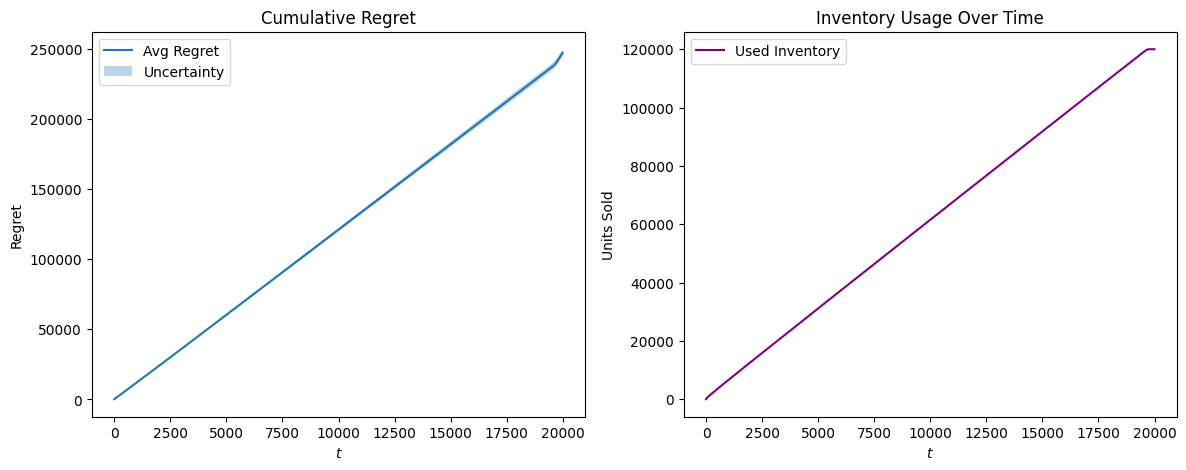

In [15]:
# Compute cumulative regret over multiple trials
regret_per_trial = []
inventory_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_expected_profit, T)

for seed in range(n_trials):
    np.random.seed(seed)

    # To visualize the chosen arms on the last trial
    if seed == n_trials - 1:
        actions_in_time = []
        gamma_best_trace = []
    
    # Create environment using new valuations
    valuations = np.random.normal(loc=value, scale=1.0, size=buyers_per_round)
    env = PricingEnvironmentSingleProduct(valuations=valuations, cost=cost)
    
    # Initialize
    ucb_like_agent = UCBLikeInventoryAgent(K=K, B=B, T=T, range=1)
    agent_rewards = []
    inventory_trace = []

    # Run UCB1 for T rounds
    for t in range(T):

        # If it's the last trial, we want to see the gamma
        if seed == n_trials - 1:
            pi_t, gamma = ucb_like_agent.pull_arm(return_gamma=True)
        else:
            pi_t = ucb_like_agent.pull_arm()
    
        # If the inventory is exhausted, break the loop
        if pi_t is None:
            agent_rewards.extend([0] * (T - t))
            inventory_trace.extend([ucb_like_agent.inventory] * (T - t))
            break

        # To visualize the chosen arms on the last trial
        if seed == n_trials - 1:
            actions_in_time.append(P[pi_t])
            gamma_best_trace.append(gamma[best_realized_index])

        # Otherwise, proceed 
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_like_agent.update(f_t=r_t, c_t=d_t)
        agent_rewards.append(r_t)
        inventory_trace.append(ucb_like_agent.inventory)

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - np.array(agent_rewards))
    regret_per_trial.append(cumulative_regret)
    inventory_per_trial.append(inventory_trace)

    # Print progress every 5% of trials
    if (seed + 1) % 5 == 0:
        print(f"Progress: {((seed + 1) / n_trials) * 100:.0f}% completed")

# --- Compute stats ---
average_regret = np.mean(regret_per_trial, axis=0)
regret_sd = np.std(regret_per_trial, axis=0)

average_inventory = np.mean(inventory_per_trial, axis=0)
inventory_used = B - average_inventory  # cumulative consumption

# --- Plot: Regret and Budget Usage ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Regret plot
ax1.plot(np.arange(T), average_regret, label='Avg Regret')
ax1.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, label='Uncertainty')
ax1.set_title('Cumulative Regret')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Regret')
ax1.legend()

# Inventory usage plot
ax2.plot(np.arange(T), inventory_used, label='Used Inventory', color='purple')
ax2.set_title('Inventory Usage Over Time')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Units Sold')
ax2.legend()

### Let's visualize the most chosen arms.

What we will notice in the following analysis (more precisely, in the next two cells), is that the optimal price would be too "expensive" in terms of budget: indeed, it is of course part of the optimal policy, but with a lower probability (which converges to around 0.2), in favour of an arm which provides higher income but sells less. In some sense, this mix is much better than only playing the optimal price, because playing the optimal price we would finish the budget very early, while here we take some time to try to sell at a higher price a fixed number of articles B.

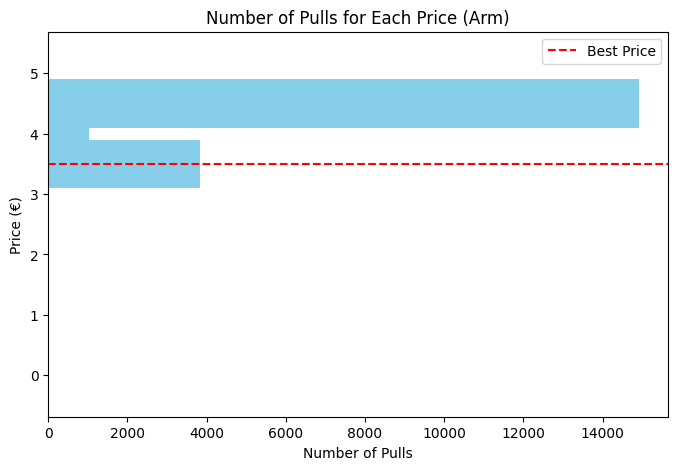

In [16]:
# --- Chosen arms on the alst trial ---
plt.figure(figsize=(8, 5))
plt.barh(P, ucb_like_agent.N_pulls, color='skyblue')  # Usa i prezzi come y invece degli indici
plt.axhline(P[best_realized_index], color='red', linestyle='--', label='Best Price')  # Linea orizzontale al prezzo migliore
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
plt.legend()

### And the order they were chosen with.

<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:19: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:19: SyntaxWarning: invalid escape sequence '\g'
/var/folders/zn/rf3j_pdd4_d02m04l2_1fjcw0000gn/T/ipykernel_34576/1859476682.py:16: SyntaxWarning: invalid escape sequence '\g'
  ax2.plot(rounds_last, gamma_best_trace, linewidth=1.5, label=f"$\gamma_{{best}}$ for price {P[best_realized_index]:.2f}€")
/var/folders/zn/rf3j_pdd4_d02m04l2_1fjcw0000gn/T/ipykernel_34576/1859476682.py:19: SyntaxWarning: invalid escape sequence '\g'
  ax2.set_ylabel(f"$\gamma_{{best}}$")


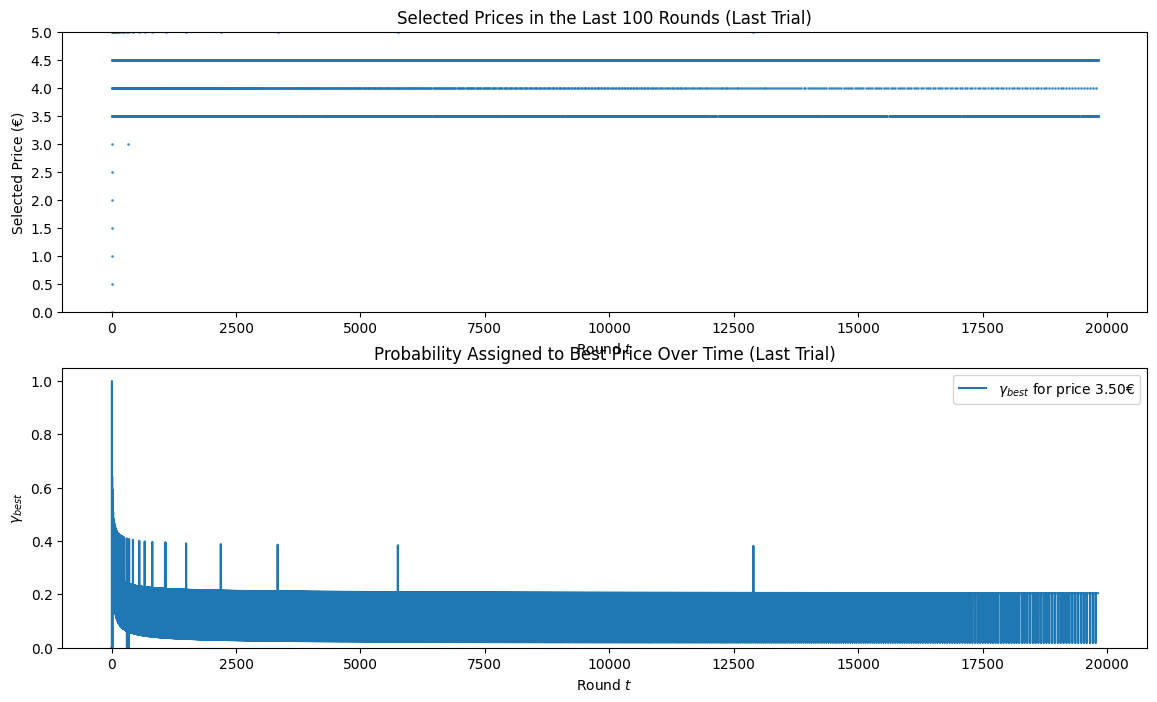

In [17]:
# Take the enumeration of the rounds
rounds_last = np.arange(len(actions_in_time))

# --- Plot: Selected Prices and Gamma for the Best Price ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# Top: selected prices
ax1.plot(rounds_last, actions_in_time, '.', markersize=2, alpha=0.7)
ax1.set_title("Selected Prices in the Last 100 Rounds (Last Trial)")
ax1.set_xlabel("Round $t$")
ax1.set_ylabel("Selected Price (€)")
ax1.set_yticks(np.arange(0, 5.5, 0.5))
ax1.set_ylim(0, 5)

# Bottom: gamma for the best price 
ax2.plot(rounds_last, gamma_best_trace, linewidth=1.5, label=f"$\gamma_{{best}}$ for price {P[best_realized_index]:.2f}€")
ax2.set_title("Probability Assigned to Best Price Over Time (Last Trial)")
ax2.set_xlabel("Round $t$")
ax2.set_ylabel(f"$\gamma_{{best}}$")
ax2.set_ylim(0, 1.05)
ax2.legend()

### Let's compare our algorithm against budget-constrained clairvoyants.

As we could see in the previous regret plot, it seems that the regret is not as good as we would expect, given the theoretical guarantees. The reason in this case is that we are comparing an algorithm playing with a very low budget - thus looking for a mix which lets it save items until the very latest rounds - against a clairvoyant which can keep selling as many items as wanted at each round. Thus, it's clear that the regret gets linear: the algorithm is literally learning how often to play the optimal move, playing a suboptimal one for the most times. In the following analysis we will see that even the best clairvoyant - which plays with a fixed arm, and not with a mixed policy - cannot beat our algorithm in the given setting. We also provide the comparison with a mixed strategy - properly said - clairvoyant.

In [18]:
# --- Clairvoyant fixed price under inventory constraint ---

expected_profits = []
expected_units = []

# Compute expected total profit for each price, under the inventory constraint B
for p, d in zip(P, expected_demand_vector):
    total_units = d * T                        # total units that could be sold at price p (if unlimited inventory)
    capped_units = min(total_units, B)        # actual units that can be sold given the inventory constraint
    profit = (p - cost) * capped_units        # expected total profit at this price
    expected_profits.append(profit)
    expected_units.append(capped_units)

expected_profits = np.array(expected_profits)
expected_units = np.array(expected_units)

# Select the best fixed price (clairvoyant choice under constraint)
best_index = np.argmax(expected_profits)
best_price = P[best_index]
best_profit = expected_profits[best_index]

# Print results for the fixed-price clairvoyant
print(f"--- Fixed Price Clairvoyant ---")
print(f"Best price: {best_price:.2f}")
print(f"Expected total profit: {best_profit:.2f}")
print(f"Expected units sold: {expected_units[best_index]:.0f}")

# Compute reward vector over T rounds for this fixed price
price_fixed = best_price
demand_fixed = expected_demand_vector[best_index]
reward_per_round_fixed = (price_fixed - cost) * demand_fixed

max_rounds_full = int(B // demand_fixed)  # how many full rounds can be executed
remaining_budget = B - (max_rounds_full * demand_fixed)
partial_reward = (price_fixed - cost) * remaining_budget if remaining_budget > 0 else 0

clairvoyant_rewards_fixed = np.zeros(T)
clairvoyant_rewards_fixed[:max_rounds_full] = reward_per_round_fixed
if max_rounds_full < T:
    clairvoyant_rewards_fixed[max_rounds_full] = partial_reward

# --- Clairvoyant mixed strategy under budget constraint ---

expected_rewards = (P - cost) * expected_demand_vector
expected_costs = expected_demand_vector
rho = B / T  # average budget per round

# Solve LP to find optimal randomized (mixed) pricing strategy under budget constraint
c = -expected_rewards  # we maximize reward → minimize negative reward
A_ub = [expected_costs]  # constraint: average cost per round <= rho
b_ub = [rho]
A_eq = [np.ones(K)]  # probabilities must sum to 1
b_eq = [1]

res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1), method='highs')
gamma_star = res.x  # optimal price distribution (clairvoyant mixed strategy)
clairvoyant_mixed_reward_per_round = np.dot(gamma_star, expected_rewards)
clairvoyant_mixed_total_reward = clairvoyant_mixed_reward_per_round * T
clairvoyant_rewards_mixed = np.full(T, clairvoyant_mixed_reward_per_round)

# Print results for the mixed-strategy clairvoyant
print(f"\n--- Mixed Strategy Clairvoyant ---")
print(f"Optimal mixed strategy (gamma*): {np.round(gamma_star, 4)}")
print(f"Expected reward per round: {clairvoyant_mixed_reward_per_round:.4f}")
print(f"Expected total reward: {clairvoyant_mixed_total_reward:.2f}")

--- Fixed Price Clairvoyant ---
Best price: 4.00
Expected total profit: 240000.00
Expected units sold: 120000

--- Mixed Strategy Clairvoyant ---
Optimal mixed strategy (gamma*): [0.     0.     0.     0.     0.     0.     0.     0.     0.5791 0.4209
 0.    ]
Expected reward per round: 12.7029
Expected total reward: 254058.27


### Visualize.

Progress: 5% completed
Progress: 10% completed
Progress: 15% completed
Progress: 20% completed
Progress: 25% completed
Progress: 30% completed
Progress: 35% completed
Progress: 40% completed
Progress: 45% completed
Progress: 50% completed
Progress: 55% completed
Progress: 60% completed
Progress: 65% completed
Progress: 70% completed
Progress: 75% completed
Progress: 80% completed
Progress: 85% completed
Progress: 90% completed
Progress: 95% completed
Progress: 100% completed
Final value of the regret vs fixed clairvoyant: -12561.840000003034
Final value of the regret vs mixed clairvoyant: 1496.4293624596519


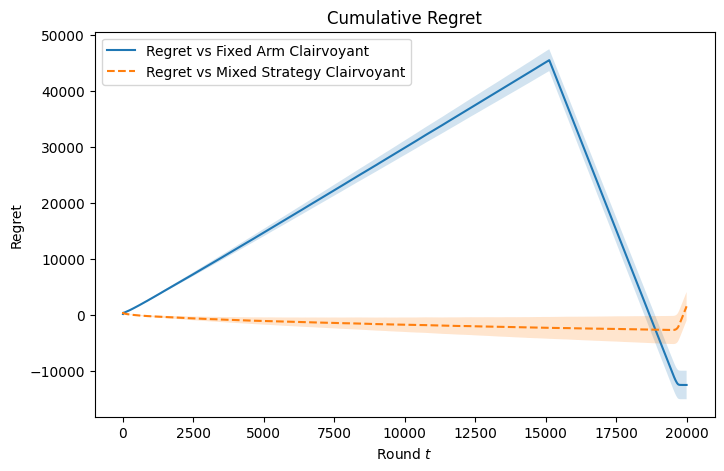

In [20]:
# --- Run algorithm and compute regret against both baselines ---

regret_vs_fixed = []
regret_vs_mixed = []
inventory_trace_list = []

for seed in range(n_trials):
    np.random.seed(seed)

    if seed == n_trials - 1:
        actions_in_time = []
        gamma_trace = []

    valuations = np.random.normal(loc=value, scale=1.0, size=buyers_per_round)
    env = PricingEnvironmentSingleProduct(valuations=valuations, cost=cost)

    ucb_like_agent = UCBLikeInventoryAgent(K=K, B=B, T=T, range=1)
    rewards = []
    inventory_trace = []

    for t in range(T):
        if seed == n_trials - 1:
            action, gamma = ucb_like_agent.pull_arm(return_gamma=True)
        else:
            action = ucb_like_agent.pull_arm()

        if action is None:
            rewards.extend([0] * (T - t))
            inventory_trace.extend([ucb_like_agent.inventory] * (T - t))
            break

        if seed == n_trials - 1:
            actions_in_time.append(P[action])
            gamma_trace.append(gamma[best_index])

        price = P[action]
        demand, reward = env.round(price)
        ucb_like_agent.update(f_t=reward, c_t=demand)
        rewards.append(reward)
        inventory_trace.append(ucb_like_agent.inventory)

    rewards = np.array(rewards)
    regret_vs_fixed.append(np.cumsum(clairvoyant_rewards_fixed - rewards))
    regret_vs_mixed.append(np.cumsum(clairvoyant_rewards_mixed - rewards))
    inventory_trace_list.append(inventory_trace)

    # Print progress every 5% of trials
    if (seed + 1) % 5 == 0:
        print(f"Progress: {((seed + 1) / n_trials) * 100:.0f}% completed")

# --- Compute stats ---

avg_regret_fixed = np.mean(regret_vs_fixed, axis=0)
std_regret_fixed = np.std(regret_vs_fixed, axis=0)

avg_regret_mixed = np.mean(regret_vs_mixed, axis=0)
std_regret_mixed = np.std(regret_vs_mixed, axis=0)

avg_inventory_used = B - np.mean(inventory_trace_list, axis=0)

# --- Plots ---

plt.figure(figsize=(8, 5))

# Plot regret vs fixed clairvoyant
plt.plot(avg_regret_fixed, label='Regret vs Fixed Arm Clairvoyant')
plt.fill_between(np.arange(T), avg_regret_fixed - std_regret_fixed / np.sqrt(n_trials), avg_regret_fixed + std_regret_fixed / np.sqrt(n_trials), alpha=0.2)

# Plot regret vs mixed clairvoyant
plt.plot(avg_regret_mixed, label='Regret vs Mixed Strategy Clairvoyant', linestyle='--')
plt.fill_between(np.arange(T), avg_regret_mixed - std_regret_mixed / np.sqrt(n_trials), avg_regret_mixed + std_regret_mixed / np.sqrt(n_trials), alpha=0.2)

print("Final value of the regret vs fixed clairvoyant:", avg_regret_fixed[-1])
print("Final value of the regret vs mixed clairvoyant:", avg_regret_mixed[-1])

# Styling
plt.title("Cumulative Regret")
plt.xlabel("Round $t$")
plt.ylabel("Regret")
plt.legend()